In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from datetime import datetime, date

from scipy.fftpack import fft, ifft, fftfreq
from scipy import signal
from scipy.signal import butter, lfilter,freqs,filtfilt,sosfilt,sosfiltfilt
from numpy import hanning

In [2]:
def time_since_start(t):
    dt = datetime.strptime(t, "%d-%b-%Y %H:%M:%S")
    return np.array([dt.year, dt.month, dt.day])

def get_month_year(times):
    deltas = np.array([time_since_start(t) for t in times])
    return (deltas[:, 0], deltas[:, 1], deltas[:, 2])

def clean(df):
    temps = df.copy()[df.columns[np.hstack([np.isin(["TEMPERATURE"], el) for el in [s.split("_") for s in df.columns.values]])]]
    precip = df.copy()[df.columns[np.hstack([not np.isin(["TEMPERATURE"], el) for el in [s.split("_") for s in df.columns.values]])]]
    years, months, days = get_month_year(df["LOCAL_DATE"])
    temps["Year"] = years
    temps["Month"] = months
    temps["Day"] = days
    precip["Year"] = years
    precip["Month"] = months
    precip["Day"] = days
    
    return temps.reset_index().drop(columns="index").query("Year >= 1960").reset_index(drop=True), precip.drop(columns="LOCAL_DATE").reset_index().drop(columns="index").query("Year >= 1960").reset_index(drop=True)


In [3]:
temps, precip = clean(pd.read_csv("Canadian_climate_history.csv"))

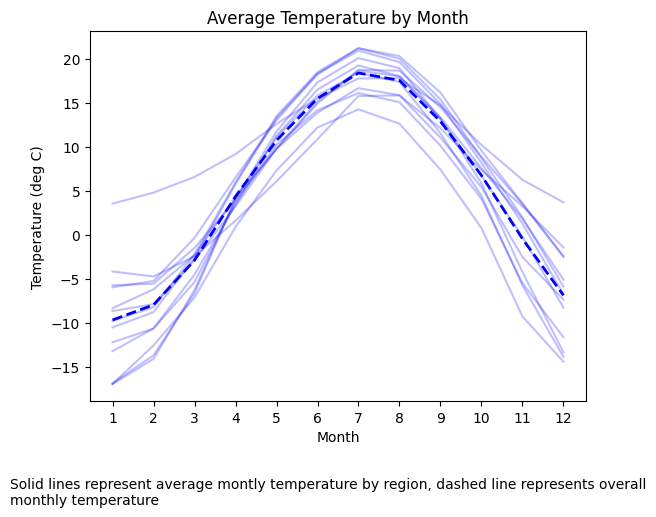

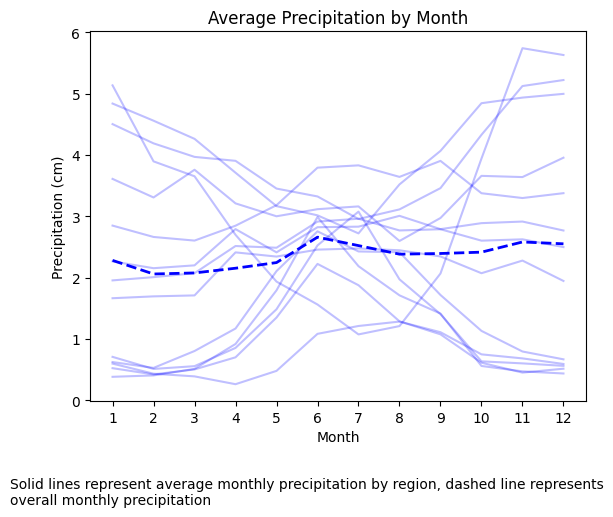

In [4]:
monthly_ave_temp = temps.groupby("Month").mean()
monthly_ave_precip = precip.groupby("Month").mean()

fig, ax = plt.subplots()
monthly_ave_temp.drop(columns=["Year", "Day"]).plot(c='b', alpha=0.25, ax=ax, legend=False)
monthly_ave_temp_overall = monthly_ave_temp.drop(columns=["Year", "Day"]).mean(axis=1)
ax.plot(np.arange(1, 13), monthly_ave_temp_overall, c='b', linewidth=2, linestyle="dashed", label="Overall Average Temperature")
ax.set_xticks(np.arange(1, 13))
ax.set_ylabel("Temperature (deg C)")
ax.set_title("Average Temperature by Month")
plt.figtext(0, -0.1, "Solid lines represent average montly temperature by region, dashed line represents overall monthly temperature", wrap=True)

fig, ax = plt.subplots()
monthly_ave_precip.drop(columns=["Year", "Day"]).plot(c='b', alpha=0.25, ax=ax, legend=False)
monthly_ave_precip_overall = monthly_ave_precip.drop(columns=["Year", "Day"]).mean(axis=1)
ax.plot(np.arange(1, 13), monthly_ave_precip_overall, c='b', linewidth=2, linestyle="dashed", label="Overall Average Precipitation")
ax.set_xticks(np.arange(1, 13))
ax.set_ylabel("Precipitation (cm)")
ax.set_title("Average Precipitation by Month")
plt.figtext(0, -0.1, "Solid lines represent average monthly precipitation by region, dashed line represents overall monthly precipitation", wrap=True);



In [16]:
temps, precip = clean(pd.read_csv("Canadian_climate_history.csv"))
precipitations = precip.loc[:, ["Year", "TOTAL_PRECIPITATION_EDMONTON"]].dropna().reset_index(drop=True)
temperatures = temps.loc[:, ["Year", "MEAN_TEMPERATURE_EDMONTON"]].dropna().reset_index(drop=True)
precip = precipitations.iloc[:, 1]
temp = temperatures.iloc[:, 1]
r = np.linspace(ticks[0], ticks[-1], len(precip))

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
21485    0.0
21486    0.0
21487    0.0
21488    0.0
21489    0.0
Name: TOTAL_PRECIPITATION_EDMONTON, Length: 21490, dtype: float64

## -----------------------------------------------------------------------------
## FFT OF TEMPERATURE AND PRECIPITATION
## -----------------------------------------------------------------------------

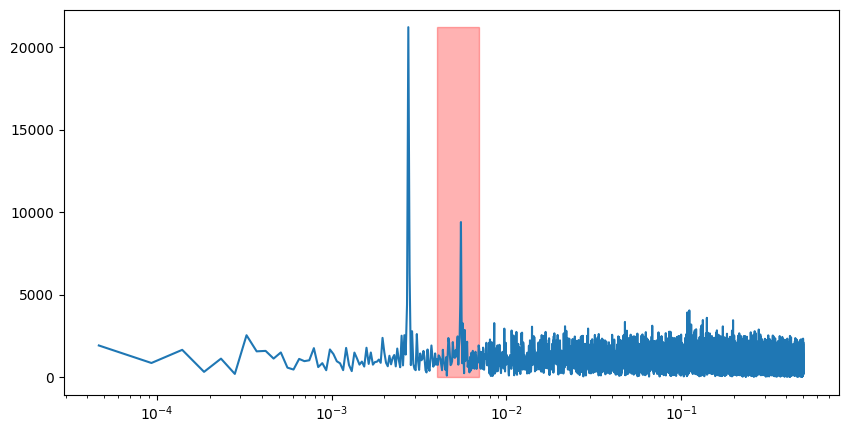

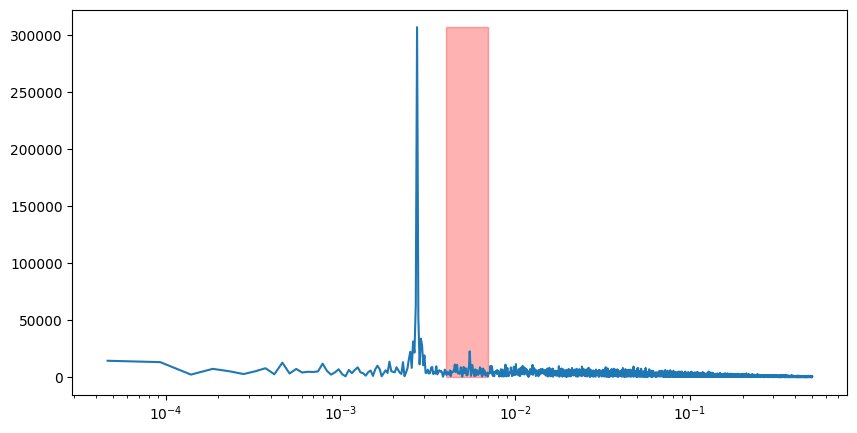

In [357]:
fft_precip = fft(precip.values)
fft_temp = fft(temp.values)
freq = fftfreq(len(precip), 1)
i = np.where(freq > 0)
freq = freq[i]
fft_precip = fft_precip[i]
fft_temp = fft_temp[i]
fc1 = fc[1] if len(fc) > 1 else max(freq)

fig, ax = plt.subplots(figsize=(10, 5))
ax.semilogx(freq, 2*abs(fft_precip))
ax.add_patch(patches.Rectangle((fc[0], 0), fc1 - fc[0], max(2 * abs(fft_precip)), color='r', alpha=0.3))

fig, ax = plt.subplots(figsize=(10, 5))
ax.semilogx(freq, 2*abs(fft_temp))
ax.add_patch(patches.Rectangle((fc[0], 0), fc1 - fc[0], max(2 * abs(fft_temp)), color='r', alpha=0.3));

## -----------------------------------------------------------------------------
## BANDPASS FILTER TO SELECT YEARLY FLUCTUATION IN PRECIPITATION AND TEMPERATURE
## -----------------------------------------------------------------------------

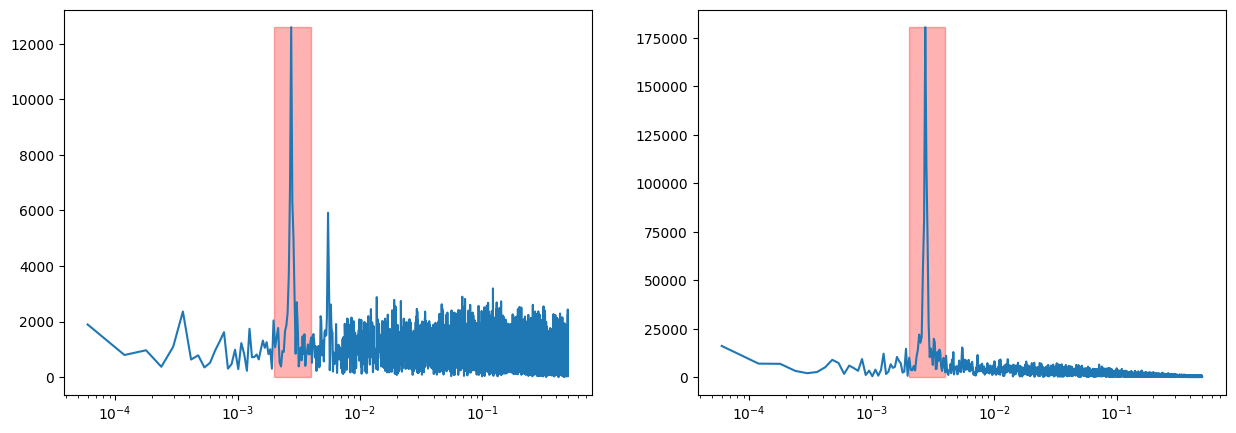

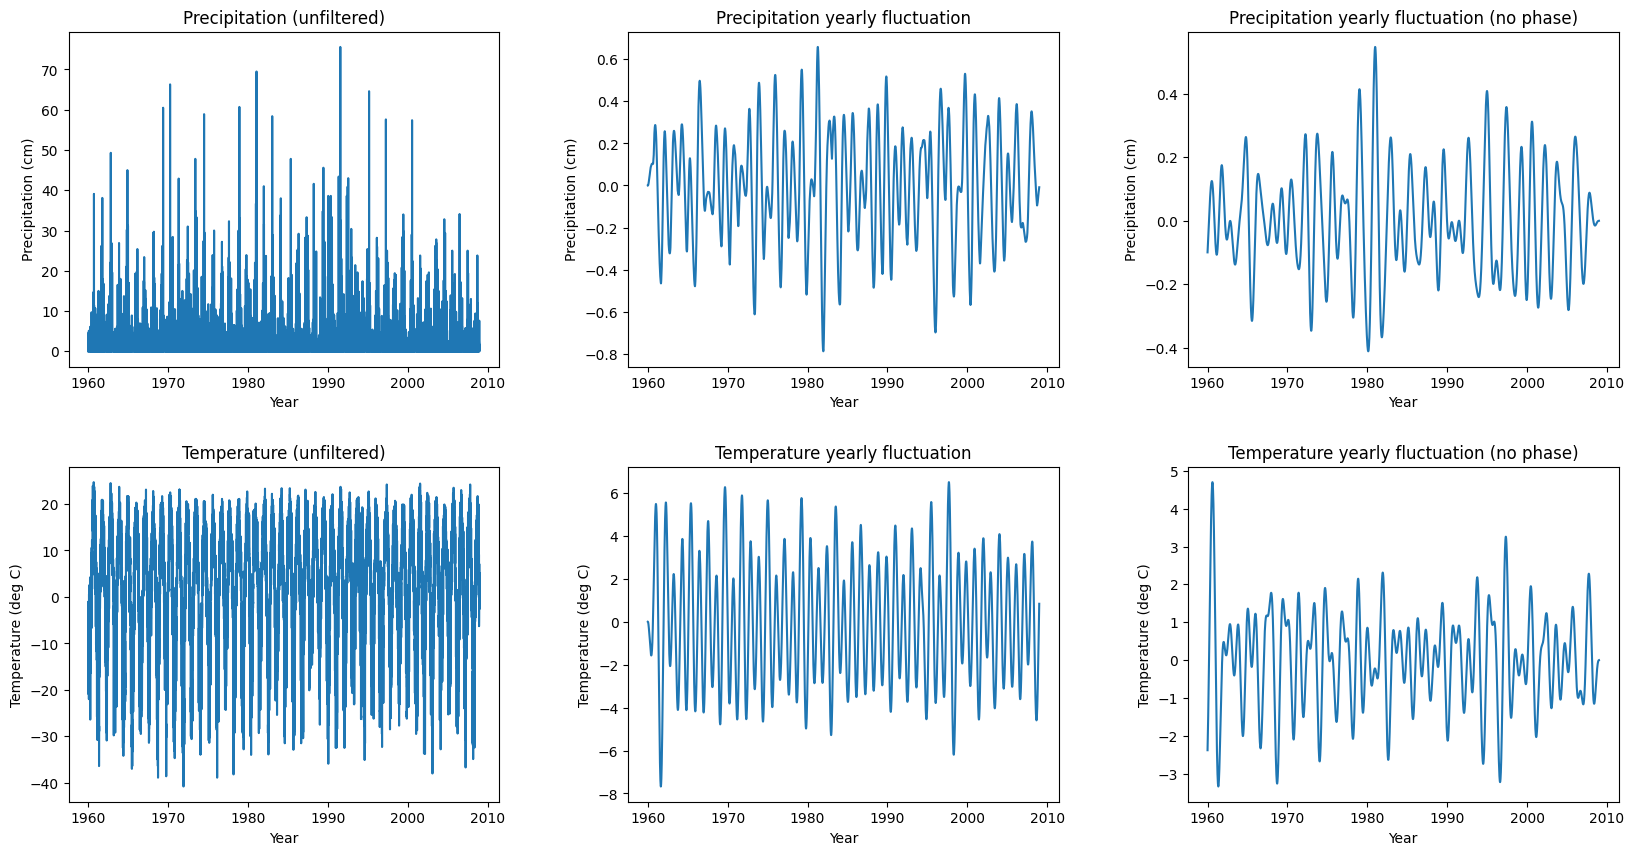

In [230]:
poles = 2
fc = [2e-3, 4e-3]
sos = butter(poles, fc, 'bandpass', output='sos')

yearly_filtered_precip = sosfilt(sos, precip)
yearly_filtfilt_precip = sosfiltfilt(sos, precip)
yearly_filtered_temp = sosfilt(sos, temp)
yearly_filtfilt_temp = sosfiltfilt(sos, temp)

to_plot = [precip, yearly_filtered_precip, yearly_filtfilt_precip, temp, yearly_filtered_temp, yearly_filtfilt_temp]
titles = ["Precipitation (unfiltered)", 
          "Precipitation yearly fluctuation", 
          "Precipitation yearly fluctuation (no phase)",
          "Temperature (unfiltered)", 
          "Temperature yearly fluctuation", 
          "Temperature yearly fluctuation (no phase)"]
ylabels = [
    "Precipitation (cm)",
    "Precipitation (cm)",
    "Precipitation (cm)",
    "Temperature (deg C)",
    "Temperature (deg C)",
    "Temperature (deg C)"
]

fc1 = fc[1] if len(fc) > 1 else max(freq)

fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(15, 5))
ax1.semilogx(freq, 2*abs(fft_precip))
ax1.add_patch(patches.Rectangle((fc[0], 0), fc1 - fc[0], max(2 * abs(fft_precip)), color='r', alpha=0.3))

ax2.semilogx(freq, 2*abs(fft_temp))
ax2.add_patch(patches.Rectangle((fc[0], 0), fc1 - fc[0], max(2 * abs(fft_temp)), color='r', alpha=0.3));


fig, axes = plt.subplots(2, 3, figsize=(20, 10))

j = 0
for row in axes:
    for ax in row:
        ax.plot(r, to_plot[j])
        ax.set_title(titles[j])
        ax.set_xlabel("Year")
        ax.set_ylabel(ylabels[j])
        j += 1

plt.subplots_adjust(hspace=0.3, wspace=0.3)



## -----------------------------------------------------------------------------
## BANDPASS FILTER TO SELECT BI-YEARLY FLUCTUATION IN PRECIPITATION
## -----------------------------------------------------------------------------

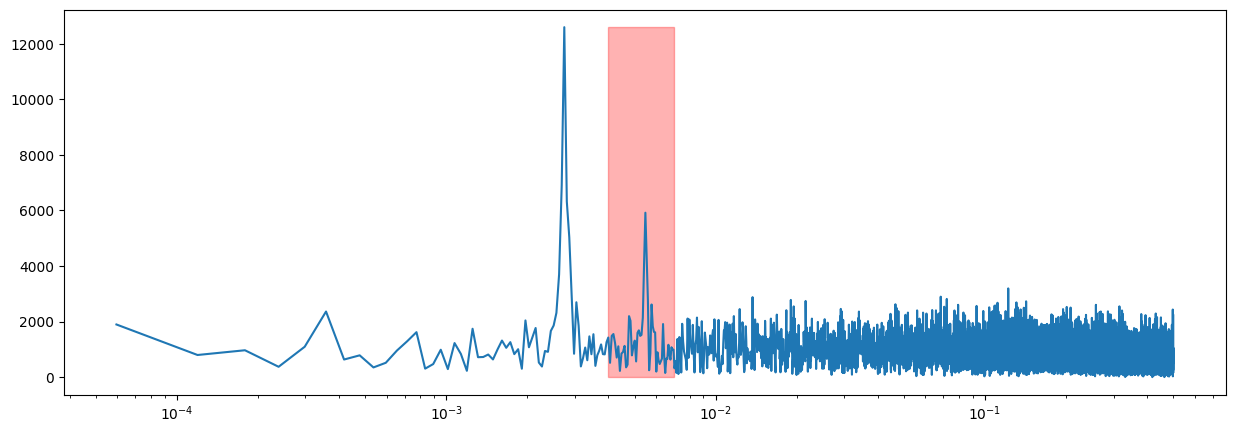

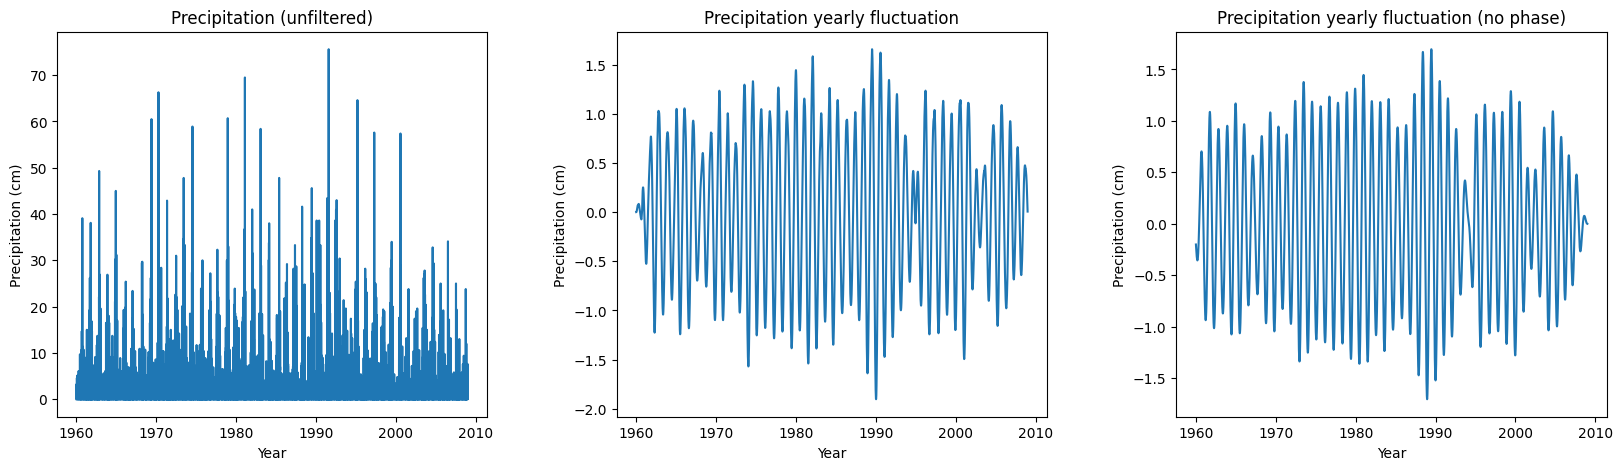

In [296]:
poles = 2
fc = [4e-3, 7e-3]
sos = butter(poles, fc, 'bandpass', output='sos')

yearly_filtered_precip = sosfilt(sos, precip)
yearly_filtfilt_precip = sosfiltfilt(sos, precip)

to_plot = [precip, yearly_filtered_precip, yearly_filtfilt_precip, temp, yearly_filtered_temp, yearly_filtfilt_temp]
titles = ["Precipitation (unfiltered)", 
          "Precipitation yearly fluctuation", 
          "Precipitation yearly fluctuation (no phase)"
         ]
ylabels = [
    "Precipitation (cm)",
    "Precipitation (cm)",
    "Precipitation (cm)",
]

fc1 = fc[1] if len(fc) > 1 else max(freq)

fig, ax  = plt.subplots(1, figsize=(15, 5))
ax.semilogx(freq, 2*abs(fft_precip))
ax.add_patch(patches.Rectangle((fc[0], 0), fc1 - fc[0], max(2 * abs(fft_precip)), color='r', alpha=0.3))


fig, axes = plt.subplots(1, 3, figsize=(20, 5))

j = 0
for ax in axes:
    ax.plot(r, to_plot[j])
    ax.set_title(titles[j])
    ax.set_xlabel("Year")
    ax.set_ylabel(ylabels[j])
    j += 1

plt.subplots_adjust(hspace=0.3, wspace=0.3)

## -----------------------------------------------------------------------------
## BANDPASS FILTER TO SELECT SHORT-TERM FLUCTUATION IN PRECIPITATION AND TEMPERATURE
## -----------------------------------------------------------------------------

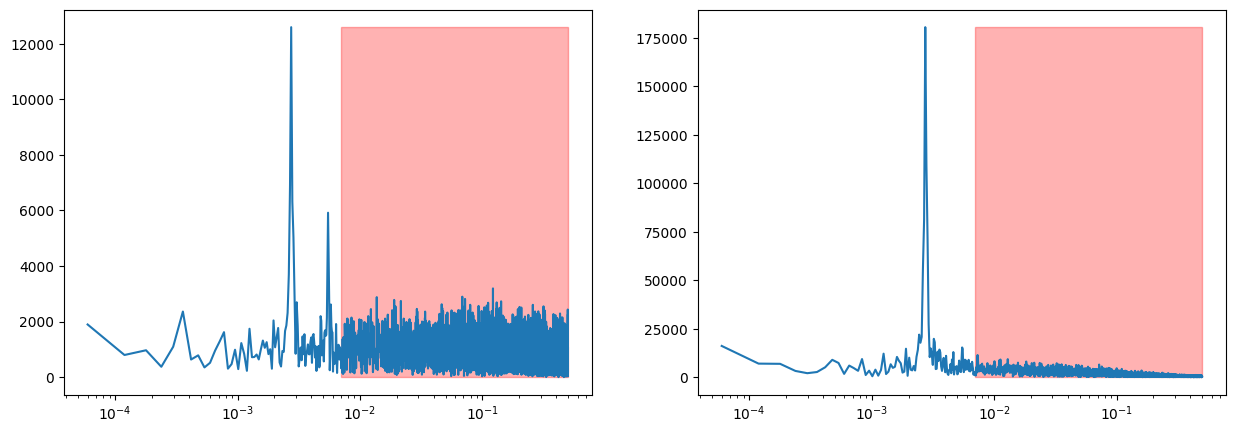

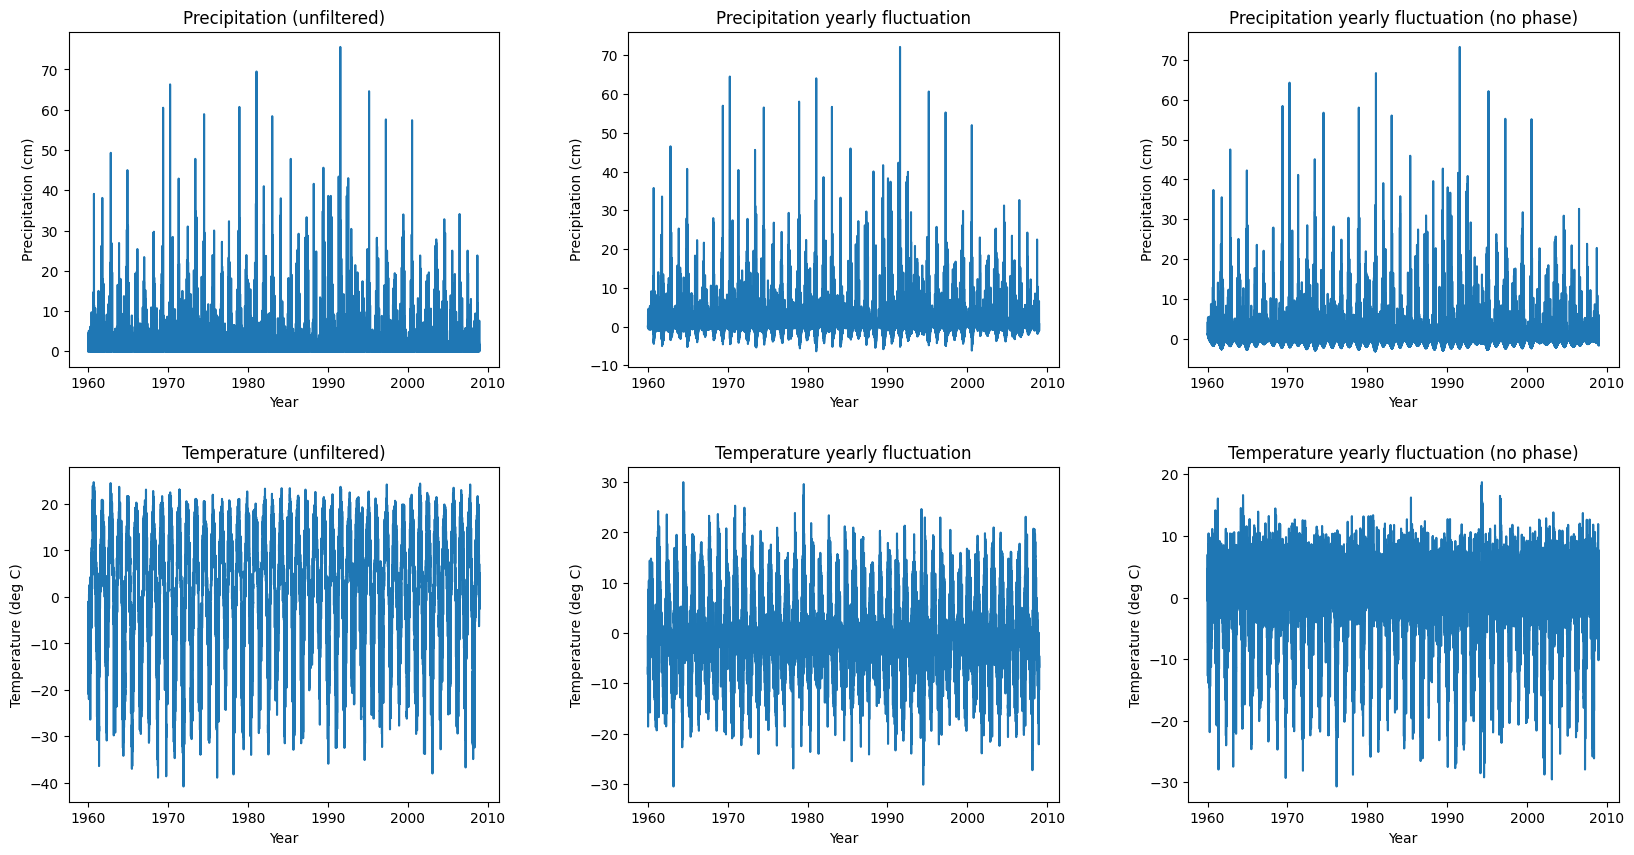

In [295]:
poles = 2
fc = [7e-3]
sos = butter(poles, fc, 'highpass', output='sos')

yearly_filtered_precip = sosfilt(sos, precip)
yearly_filtfilt_precip = sosfiltfilt(sos, precip)
yearly_filtered_temp = sosfilt(sos, temp)
yearly_filtfilt_temp = sosfiltfilt(sos, temp)

to_plot = [precip, yearly_filtered_precip, yearly_filtfilt_precip, temp, yearly_filtered_temp, yearly_filtfilt_temp]
titles = ["Precipitation (unfiltered)", 
          "Precipitation yearly fluctuation", 
          "Precipitation yearly fluctuation (no phase)",
          "Temperature (unfiltered)", 
          "Temperature yearly fluctuation", 
          "Temperature yearly fluctuation (no phase)"]
ylabels = [
    "Precipitation (cm)",
    "Precipitation (cm)",
    "Precipitation (cm)",
    "Temperature (deg C)",
    "Temperature (deg C)",
    "Temperature (deg C)"
]

fc1 = fc[1] if len(fc) > 1 else max(freq)

fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(15, 5))
ax1.semilogx(freq, 2*abs(fft_precip))
ax1.add_patch(patches.Rectangle((fc[0], 0), fc1 - fc[0], max(2 * abs(fft_precip)), color='r', alpha=0.3))

ax2.semilogx(freq, 2*abs(fft_temp))
ax2.add_patch(patches.Rectangle((fc[0], 0), fc1 - fc[0], max(2 * abs(fft_temp)), color='r', alpha=0.3));

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

j = 0
for row in axes:
    for ax in row:
        ax.plot(r, to_plot[j])
        ax.set_title(titles[j])
        ax.set_xlabel("Year")
        ax.set_ylabel(ylabels[j])
        j += 1

plt.subplots_adjust(hspace=0.3, wspace=0.3)

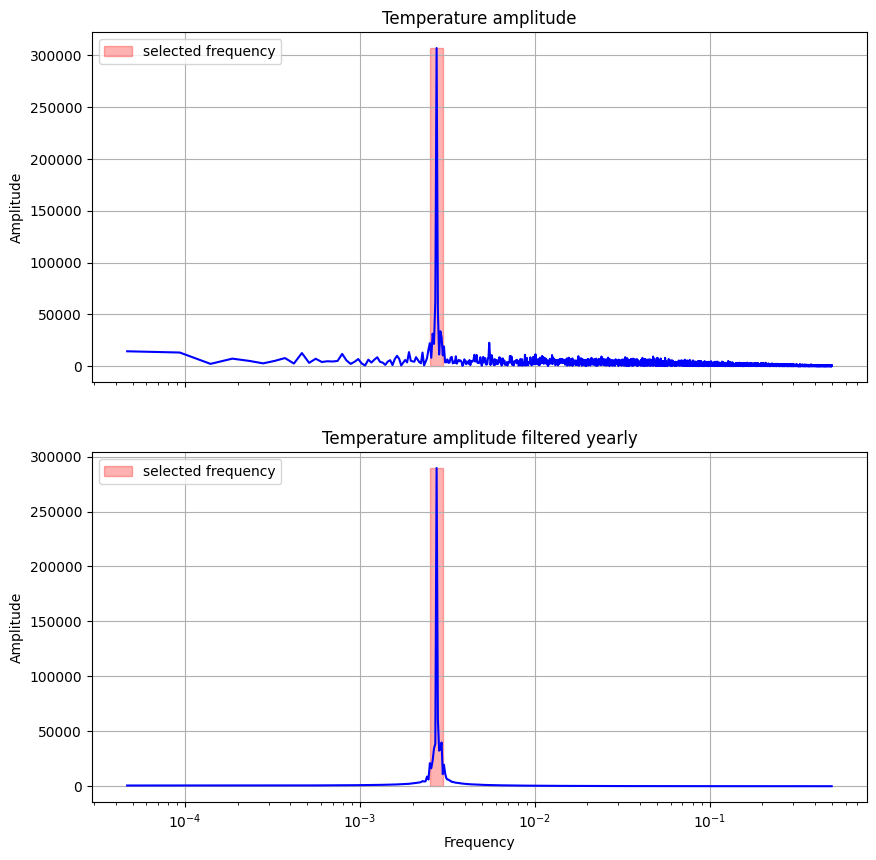

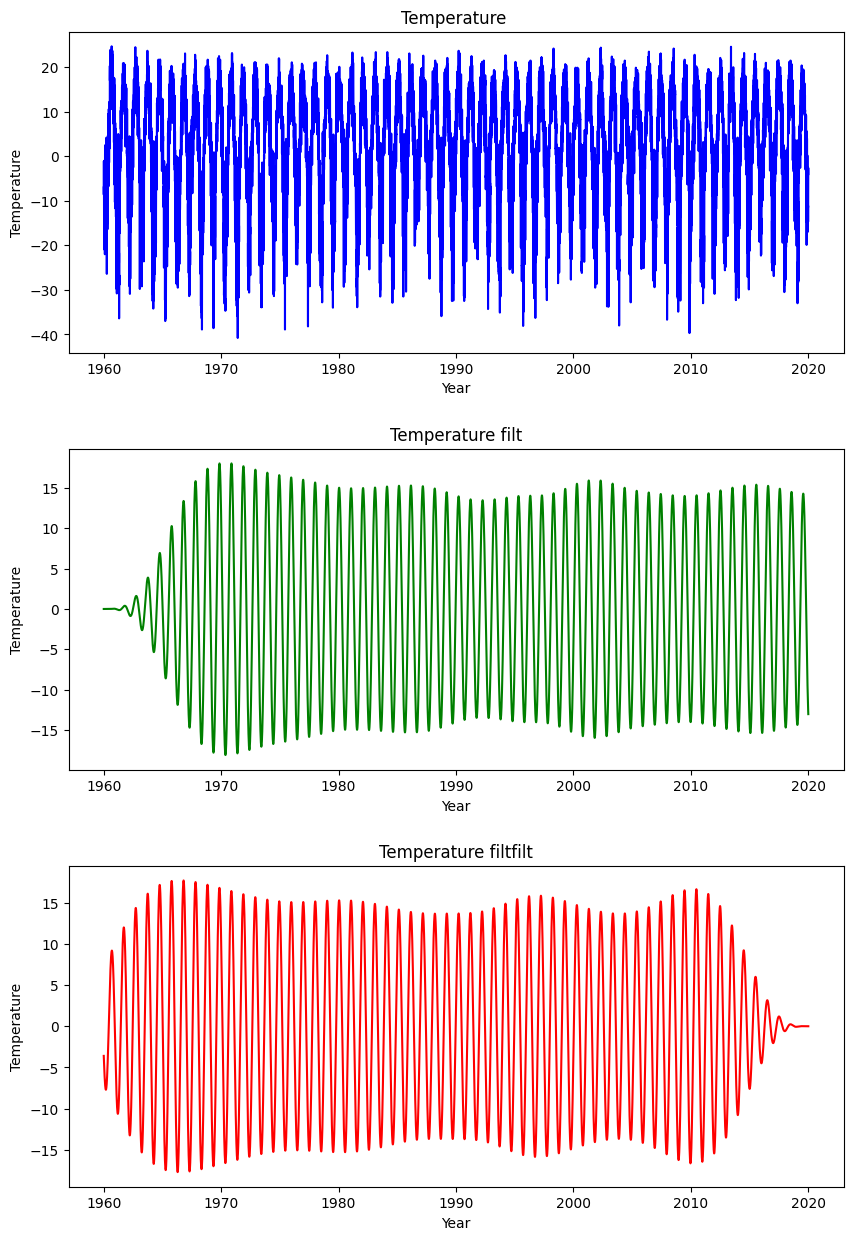

In [538]:
class Analyzer:
    def __init__(self, label : str, values : pd.DataFrame, yearly_freq : np.ndarray, bi_yearly_freq : np.ndarray, poles : int):
        # initialize variables
        """
        label : str
            label to be used for plot titles and axis labels

        values : pd.DataFrame
            dataframe with two columns containing years and data

        yearly_freq : np.ndarray
            array with two elements, specifying the range of frequencies to select to isolate yearly variation

        bi_yearly_freq : np.ndarray
            array with two elements, specifying the range of frequencies to select to isolate bi-yearly variation

        poles : int
            number of poles to be used for the butterworth filter 
        """

        self.label = label
        self.x = values.iloc[:, 0].values # array of ints corresponding to the year of collection for each data point
        self.y = values.iloc[:, 1].values # array of ints containing the recorded data points
        self.yearly_freq = 2 * yearly_freq # normalizes the yearly frequency range 
        self.bi_yearly_freq = 2 * bi_yearly_freq # normalizes the bi-yearly frequency range
        self.poles = poles # number of poles to use in the butterworth filter
        self.freq = fftfreq(len(self.y), 1) # frequency values for amplitude spectrum
        self.high_freq = np.array([2/91, max(self.freq)])
        self.i = self.freq > 0 # index to select only positive frequencies
        self.freq = self.freq[self.i] # selects positive frequencies
        self.amplitude_spectrum = 2 * abs(fft(self.y))[self.i] # calculates ampltitude spectrum, multiplying by 2 to account for ignoring negative frequencies
        self.t = np.linspace(1960, 2020, len(self.y))
        
        self.yearly_filt = None
        self.bi_yearly_filt = None
        self.high_filt = None
        self.yearly_filtfilt = None
        self.bi_yearly_filtfilt = None
        self.high_filtfilt = None

    # filters input data to select yearly, bi-yearly, and high frequency fluctuations
    # high frequency refers to all frequencies higher than quarter-yearly / seasonally
    def filter(self):
        yearly_sos = butter(self.poles, self.yearly_freq, 'bandpass', output='sos')
        bi_yearly_sos = butter(self.poles, self.bi_yearly_freq, 'bandpass', output='sos')
        high_sos = butter(self.poles*3, self.high_freq[0], 'highpass', output='sos')
        
        self.yearly_filt = sosfilt(yearly_sos, self.y)
        self.bi_yearly_filt = sosfilt(bi_yearly_sos, self.y)
        self.high_filt = sosfilt(high_sos, self.y)
        self.yearly_filtfilt = sosfiltfilt(yearly_sos, self.y)
        self.bi_yearly_filtfilt = sosfiltfilt(bi_yearly_sos, self.y)
        self.high_filtfilt = sosfiltfilt(high_sos, self.y)

    # generates 5 plots based on input string
    # ampltiude spectrum of input data, amplitude spectrum of data after filtering, original data, filtered data, and filtfilted data
    def plots(self, which : str = 'yearly'):
        """
        which : str, default = 'yearly'
            string specifying which frequencies to select via filter
        """
        
        filt = None
        filtfilt = None
        freq_to_use = None

        # assigns correct filters and frequency to variables depending on input string
        if which == 'yearly':
            filt = self.yearly_filt
            filtfilt = self.yearly_filtfilt
            freq_to_use = self.yearly_freq
            
        elif which == 'bi-yearly':
            filt = self.bi_yearly_filt
            filtfilt = self.bi_yearly_filtfilt
            freq_to_use = self.bi_yearly_freq
            
        elif which == 'high':
            filt = self.high_filt
            filtfilt = self.high_filtfilt
            freq_to_use = self.high_freq
            
        to_plot = [self.y, filt, filtfilt]

        # defines frequency range for plotting purposes
        freq0 = freq_to_use[0] / 2 if len(freq_to_use) > 1 else freq_to_use[0] / 2
        freq1 = freq_to_use[1] / 2 if which != 'high' else freq_to_use[1]
        between = (self.freq > freq0) & (self.freq < freq1)

        # plots ampltiude spectrum of original data
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
        ax1.semilogx(self.freq, self.amplitude_spectrum, c='b')
        ax1.add_patch(patches.Rectangle((freq0, 0), freq1 - freq0, max(self.amplitude_spectrum[between]), color='r', alpha=0.3, label='selected frequency'))
        ax1.set_title(f"{self.label} amplitude")
        ax1.set_ylabel("Amplitude")
        ax1.legend(loc='upper left')
        ax1.grid()

        # plots amplitude spectrum of filtered data
        ax2.semilogx(self.freq, 2*abs(fft(filt))[self.i], c='b')
        ax2.add_patch(patches.Rectangle((freq0, 0), freq1 - freq0, max(2*abs(fft(filt))[self.i][between]), color='r', alpha=0.3, label='selected frequency'))
        ax2.set_title(f"{self.label} amplitude filtered {which}")
        ax2.set_xlabel("Frequency")
        ax2.set_ylabel("Amplitude")
        ax2.legend(loc='upper left')
        ax2.grid()

        # plots original and filtered data
        fig, axes = plt.subplots(3, 1, figsize=(10, 15))
        c = ['b', 'g', 'r']
        j = 0
        for ax in axes:
            ax.plot(self.t, to_plot[j], c=c[j])
            ax.set_title(self.label + ' ' + 'filt'*j)
            ax.set_xlabel("Year")
            ax.set_ylabel(self.label)
            j += 1
        
        plt.subplots_adjust(hspace=0.3, wspace=0.3)

    # generatres a spectrogram based on input string
    def spectro(self, which : str = 'yearly'):
        """
        which : str, default = 'yearly'
            string specifying which filter to use when generating spectrogram
        """
        nperseg = 4096
        noverlap = 4000
        
        data = None
        freq_to_use = None
        if which == 'unfiltered':
            data = self.y
            freq_to_use = np.array([min(self.freq), max(self.freq)])
        elif which == 'yearly':
            data = self.yearly_filt
            freq_to_use = self.yearly_freq
        elif which == 'yearly-filtfilt':
            data = self.yearly_filtfilt
            freq_to_use = self.yearly_freq
        elif which == 'bi-yearly':
            data = self.bi_yearly_filt
            freq_to_use = self.bi_yearly_freq
        elif which == 'bi-yearly-filtfilt':
            data = self.bi_yearly_filtfilt
            freq_to_use = self.bi_yearly_freq
        elif which == 'high':
            data = self.high_filt
            freq_to_use = self.high_freq
        elif which =='high-filtfilt':
            data = self.high_filtfilt
            freq_to_use = self.high_freq

        F, T, Sxx = signal.spectrogram(data, 1,nperseg=nperseg,noverlap=noverlap)

        plt.figure()
        plt.subplot(2,1,2)
        ax = plt.gca()
        ax.set_yscale('log')
        plt.pcolormesh(T,F,np.log(Sxx),cmap='turbo')
        plt.colorbar(orientation='horizontal')
        plt.ylim([1e-3, 1e-1])
        # plt.axhline(1/365, c='b', linestyle='dotted', linewidth=2)
        # plt.axhline(1/182, c='b', linestyle='dotted', lw=2)
        
        plt.subplot(2,1,1)
        plt.plot(self.t, self.y)
        
    def plot_data(self):
        plt.plot(self.t, self.y)

    def plot_filtered(self, which : str = 'yearly'):
        data = self.yearly_filt
        if which == 'high':
            data = self.high_filt
        elif which == 'bi_yearly':
            data = self.bi_yearly_filt
        plt.plot(self.t, data)
        
    def plot_filtfilt(self, which : str = 'yearly'):
        data = self.yearly_filtfilt
        if which == 'high':
            data = self.high_filtfilt
        elif which == 'bi_yearly':
            data = self.bi_yearly_filtfilt
        plt.plot(self.t, data)

precip_analyzer = Analyzer("Precipitation", precipitations, np.array([2.5e-3, 3e-3]), np.array([5e-3, 6e-3]), 4)
temp_analyzer = Analyzer("Temperature", temperatures, np.array([2.5e-3, 3e-3]), np.array([5e-3, 6e-3]), 4)
temp_analyzer.filter()
# temp_analyzer.plots("high")
# temp_analyzer.spectro("yearly")
temp_analyzer.plots()